# Import Dependencies

In [1]:
from __future__ import division
import random,pickle,csv,cv2,os,scipy,pickle,warnings,matplotlib
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.stats import norm,skew
from itertools import islice

import keras.backend as K
from keras.callbacks import History
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D,GlobalMaxPooling2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.utils import print_summary
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
from keras.optimizers import Adam,SGD
from keras import applications
from keras.utils.vis_utils import plot_model

print(os.listdir('../input/self driving car training data/data'))
warnings.filterwarnings('ignore')

['IMG', 'driving_log.csv']


Using TensorFlow backend.


# Helper Functions

In [2]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [3]:
def image_preprocessing(img):
    resized_image = cv2.resize((cv2.cvtColor(img,cv2.COLOR_RGB2HSV))[:,:,1],(40,40))
    return resized_image

In [4]:
def load_training(delta):
    logs = []
    features = []
    labels = []
    with open(labels_file,'rt') as f:
        reader = csv.reader(f)
        for line in reader:
            logs.append(line)
        log_labels = logs.pop(0)
        
    for i in range(len(logs)):
        for j in range(3):
            img_path = logs[i][j]
            img_path = features_directory + 'IMG' + (img_path.split('IMG')[1]).strip()
            img = plt.imread(img_path)
            features.append(image_preprocessing(img))
            
            if j == 0:
                labels.append(float(logs[i][3]))
            elif j == 1:
                labels.append(float(logs[i][3]) + delta)
            else:
                labels.append(float(logs[i][3]) - delta)
    return features,labels

In [5]:
def loadFromPickle():
    with open('features','rb') as f:
        features = np.array(pickle.load(f))
    with open('labels','rb') as f:
        labels = np.array(pickle.load(f))
    return features,labels

def augmentData(features,labels):
    features = np.append(features,features[:,:,::-1],axis=0)
    labels = np.append(labels,-labels,axis=0)
    return features,labels

# Load in the data

In [6]:
features_directory = '../input/self driving car training data/data/'
labels_file = '../input/self driving car training data/data/driving_log.csv'

In [7]:
delta = 0.2
features,labels = load_training(delta)

features = np.array(features).astype('float32')
labels = np.array(labels).astype('float32')

with open('features','wb') as f:
    pickle.dump(features,f,protocol=4)
with open('labels','wb') as f:
    pickle.dump(labels,f,protocol=4)

In [8]:
pan = pd.Panel(features)
df = pan.swapaxes(1,2).to_frame()
df.index = df.index.droplevel('major')
df.index = df.index+1

In [9]:
features,labels = loadFromPickle()
features,labels = shuffle(features,labels)

x_train,x_val,y_train,y_val = train_test_split(features,labels,random_state=42,test_size=0.2)

x_train = x_train.reshape(x_train.shape[0],40,40,1)
x_val = x_val.reshape(x_val.shape[0],40,40,1)

# Create The Model

In [10]:
base_model = MobileNetV2(include_top=False,weights=None,input_shape=(40,40,1))

for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_40 (Model)  (None, 2, 2, 1280)        2257408   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,258,689
Trainable params: 1,281
Non-trainable params: 2,257,408
_________________________________________________________________


# Callbacks

In [11]:
#-------Callbacks-------------#
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

# Now we train the model

In [12]:
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-3)

model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)
    
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    epochs = 50, 
    verbose = 1,
    callbacks=callbacks,
    batch_size = 256
)

Instructions for updating:
Use tf.cast instead.
Train on 19286 samples, validate on 4822 samples
Epoch 1/50
19286/19286 [==============================] - 4s 221us/step - loss: 0.0183 - acc: 0.1785 - val_loss: 0.6912 - val_acc: 0.1844

Epoch 00001: val_loss improved from inf to 0.69116, saving model to ./base.model
Epoch 2/50
19286/19286 [==============================] - 1s 74us/step - loss: -0.0535 - acc: 0.1800 - val_loss: 0.6958 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.69116
Epoch 3/50
19286/19286 [==============================] - 1s 73us/step - loss: -0.0851 - acc: 0.1800 - val_loss: 0.7013 - val_acc: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.69116
Epoch 4/50
19286/19286 [==============================] - 1s 73us/step - loss: -0.1083 - acc: 0.1800 - val_loss: 0.7039 - val_acc: 0.0000e+00

Epoch 00004: val_loss did not improve from 0.69116
Epoch 5/50
19286/19286 [==============================] - 1s 74us/step - loss: -0.1209 - acc: 0.1798 

# Visualize the training and save the weights and json file

Weights Saved
JSON Saved


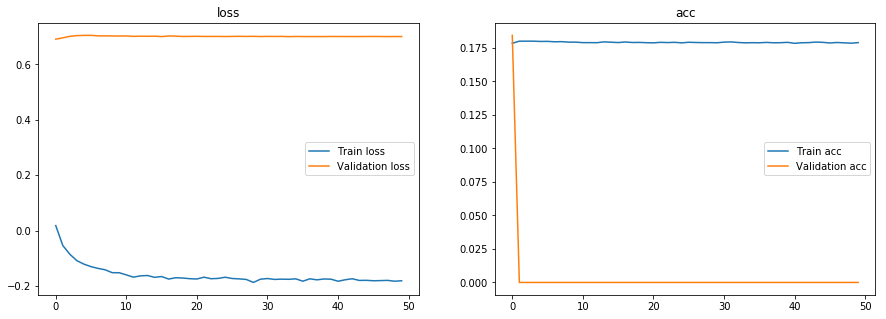

In [13]:
show_final_history(history)
model.load_weights(best_model_weights)

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")
print("Weights Saved")
print("JSON Saved")

# TensorBoard

In [14]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './logs' # Here you have to put your log directory
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 8080 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 8080 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-04-10 14:09:19--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.152.127.232, 52.72.250.2, 54.165.51.142, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.152.127.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14977695 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.28M  41.3MB/s    in 0.3s    

2019-04-10 14:09:20 (41.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14977695/14977695]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://2cd6cd60.ngrok.io
